In [1]:
import numpy as np
import tensorflow as tf
%pylab inline
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
class DataDistribution(object):
    def __init__(self, mu=4, sigma=0.5):
        self.mu = mu
        self.sigma = sigma
    def sample(self, N):
        return np.sort(np.random.normal(self.mu, self.sigma, N))

In [3]:
p_d = DataDistribution()

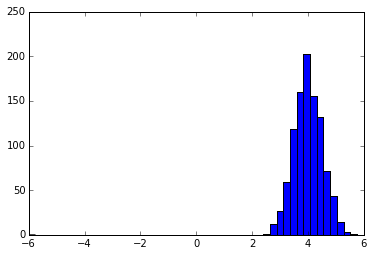

In [4]:
_ = plt.hist(p_d.sample(1000), bins=50,range=(-6,6))

In [5]:
class Noise(object):
    def __init__(self, range):
        self.range = range
    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.normal(N) * 0.01

In [6]:
def fully_connected(tensor, out_dim, scope=None, stddev=1):
    with tf.variable_scope(scope or 'fc'):
        # scopes: https://www.tensorflow.org/how_tos/variable_scope/
        w = tf.get_variable('w', \
                            shape=(tensor.get_shape()[1], out_dim), \
                            initializer=tf.random_normal_initializer(stddev=stddev))
        b = tf.get_variable('b', \
                            shape=[out_dim], \
                            initializer=tf.constant_initializer(value=0))
        return tf.matmul(tensor, w) + b

In [7]:
def generator(x, hidden_dimensions, activations):
    """
        Creates a generator network. 
        Note the number of layers in the network will be 
        len(hidden_dimensions)+1 as the last fully connected layer
        doesn't have an activation
        
        @params:
            x: the input tensor
            hidden_dimensions: the list of hidden nodes in each layer
            activations: the list of activation functions to use in each layer
        @returns:
            a tensor representing the computation from a neural network
            (the dimension of this network out will be 1, representing the p_g)
    """
    assert len(hidden_dimensions) == len(activations), \
    'must have same number of hidden_dimensions as activations'
    
    previous_layer_result = x
    for i, (h, a) in enumerate(zip(hidden_dimensions, activations)):
        previous_layer_result = a(fully_connected(previous_layer_result, h, 'g'+str(i)))

    return fully_connected(previous_layer_result, 1, 'g_out')


In [8]:
def discriminator(x, hidden_dimensions, activations):
    """
        Creates a discriminator network.
        Note the number of layers in the network will be
        len(hidden_dimensions)+1 as the last fully connected layer
        has a sigmoid activation function.
    """
    
    assert len(hidden_dimensions) == len(activations), \
    'must have the same number of hidden_dimensions as activations'
    
    previous_layer_result = x
    for i, (h, a) in enumerate(zip(hidden_dimensions, activations)):
        previous_layer_result = a(fully_connected(previous_layer_result, h, 'd'+str(i)))
    
    return tf.sigmoid(fully_connected(previous_layer_result, 1, scope='d_out'))

In [9]:
def optimizer(loss, var_list, lr_0):
    decay = 0.95
    num_decay_steps = 150
    step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        lr_0,
        step,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=step,
        var_list=var_list
    )
    return optimizer

In [10]:
BATCH_SIZE = 32
D_HIDDEN_SIZE = 4
D_LAYERS = [ D_HIDDEN_SIZE ] * 3 
D_ACTIVATIONS = [ tf.nn.tanh ] * 3
G_HIDDEN_SIZE = 4
G_LAYERS = [ G_HIDDEN_SIZE ] * 1
G_ACTIVATIONS = [ tf.nn.softplus ] * 1
LR = 0.03

In [11]:
# see scope naming here: https://www.tensorflow.org/how_tos/variable_scope/

# pretrained D
with tf.variable_scope('D_pre'):
    # the inputs are of shape b*1
    x_pre = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    # outputs are of shape b*1
    y_pre = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    D_pre = discriminator(x_pre, D_LAYERS, D_ACTIVATIONS)
    D_pre_loss = tf.reduce_mean(tf.square(D_pre - y_pre))
    D_pre_optimizer = optimizer(D_pre_loss, None, LR)
    
with tf.variable_scope('G'):
    # random noise of shape b*1
    z = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    G = generator(z, G_LAYERS, G_ACTIVATIONS)
    
with tf.variable_scope('D') as scope:
    x = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    
    # the network that will classify real data
    # D1 = D(x) 
    D1 = discriminator(x, D_LAYERS, D_ACTIVATIONS)
    scope.reuse_variables()
    
    # the network that will classify the generated data
    # D2 = D(G(z))
    D2 = discriminator(G, D_LAYERS, D_ACTIVATIONS)

In [12]:
# for the discriminator:
# we want D1 to be high and D2 to be low therefore 1-D2 to be high
D_loss = tf.reduce_mean(-tf.log(D1) - tf.log(1-D2))

# for the generator, the goal is to only fool the discriminator
# therefor we want D2 to be high and thus -log(D2) to be low
G_loss = tf.reduce_mean(-tf.log(D2))

In [13]:
PRETRAIN_STEPS = 1000
STEPS = 10000
N_points = 1000

In [14]:
variables = tf.trainable_variables()
d_pre_params = [v for v in variables if v.name.startswith('D_pre/')]
d_params = [v for v in variables if v.name.startswith('D/')]
g_params = [v for v in variables if v.name.startswith('G/')]

In [15]:
D_opt = optimizer(D_loss, d_params, LR)
G_opt = optimizer(G_loss, g_params, LR)

In [16]:
p_d = DataDistribution()
p_z = Noise(range=8)

In [17]:
init = tf.initialize_all_variables()

In [18]:
def create_samples(p_z, session, G, N_points, BATCH_SIZE):
    """
        Samples from a noise distribution p_z
        using a tf.session runs G with z drawn from p_z
    """
    g = np.zeros((N_points, 1))
    zs = p_z.sample(1000)
   
    for i in range(N_points // BATCH_SIZE):
        g[BATCH_SIZE*i: BATCH_SIZE*(i+1), :] = session.run(G,{
                z: np.reshape(zs[BATCH_SIZE*i:BATCH_SIZE*(i+1)], (BATCH_SIZE,1))
            })
        
    return g


In [19]:
sampled = {}

with tf.Session() as session:
    session.run(init)
    sampled[0] = create_samples(p_z, session, G, N_points, BATCH_SIZE)
    
    # pretraining:
    for step in xrange(PRETRAIN_STEPS):
        d = (np.random.random(BATCH_SIZE)-0.5) * 10
        labels = norm.pdf(d, loc=p_d.mu, scale=p_d.sigma)
        pretrain_loss, _ = session.run([D_pre_loss, D_pre_optimizer],{
                x_pre : np.reshape(d, (BATCH_SIZE, 1)),
                y_pre : np.reshape(labels, (BATCH_SIZE, 1))
            })
    
    sampled[1] = create_samples(p_z, session, G, N_points, BATCH_SIZE)
    print('Pretraining done')
    weightsD = session.run(d_pre_params)
    
    # assign the pretrained weights to the new D network
    for i, v in enumerate(d_params):
        session.run(v.assign(weightsD[i]))
    i = 1
    for step in xrange(STEPS):
        x_ = p_d.sample(BATCH_SIZE).reshape(-1, 1)
        z_ = p_z.sample(BATCH_SIZE).reshape(-1, 1)
        
        loss_d, _ = session.run([D_loss, D_opt], {
                x: x_,
                z: z_
            })
        
        z_ = p_z.sample(BATCH_SIZE).reshape(-1,1)
        
        loss_g, _ = session.run([G_loss, G_opt], {
                z: z_
            })
        
        if step % 100 == 0:
            i+=1
            print('STEP:'+str(step)+'/'+str(STEPS))
            print('Discriminator Loss: '+str(loss_d))
            print('Generator Loss:'+str(loss_g))
            sampled[i] = create_samples(p_z, session, G, N_points, BATCH_SIZE)
    print('TRAINING COMPLETED')
    # generate samples:
    i+=1
    sampled[i] = create_samples(p_z, session, G, N_points, BATCH_SIZE)

Pretraining done
STEP:0/10000
Discriminator Loss: 1.24635
Generator Loss:1.95402
STEP:100/10000
Discriminator Loss: 0.704478
Generator Loss:1.86254
STEP:200/10000
Discriminator Loss: 1.72643
Generator Loss:0.7994
STEP:300/10000
Discriminator Loss: 1.45859
Generator Loss:0.614563
STEP:400/10000
Discriminator Loss: 1.39033
Generator Loss:0.683743
STEP:500/10000
Discriminator Loss: 1.38806
Generator Loss:0.690231
STEP:600/10000
Discriminator Loss: 1.38755
Generator Loss:0.691851
STEP:700/10000
Discriminator Loss: 1.38665
Generator Loss:0.692761
STEP:800/10000
Discriminator Loss: 1.38669
Generator Loss:0.692264
STEP:900/10000
Discriminator Loss: 1.38867
Generator Loss:0.692661
STEP:1000/10000
Discriminator Loss: 1.38662
Generator Loss:0.69342
STEP:1100/10000
Discriminator Loss: 1.38674
Generator Loss:0.692362
STEP:1200/10000
Discriminator Loss: 1.38677
Generator Loss:0.693123
STEP:1300/10000
Discriminator Loss: 1.38683
Generator Loss:0.692992
STEP:1400/10000
Discriminator Loss: 1.38638
Gen

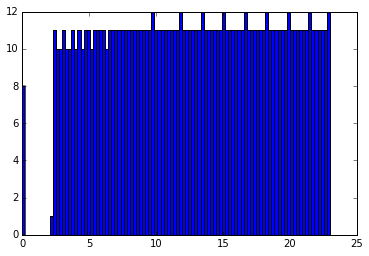

In [23]:
_ = plt.hist(sampled[0], bins=100)

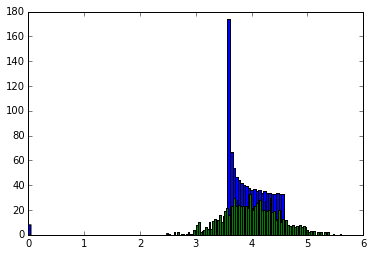

In [36]:
_ = plt.hist(sampled[102], bins=100)
_ = plt.hist(p_d.sample(1000), bins=100)